# Distributional assumption test

In [89]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy.api as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', -1)
import pickle as pkl
from scipy import sparse
import time

In [98]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'figure.titlesize':'xx-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)


In [3]:
import warnings
#warnings.warn('ignore')

In [31]:
%matplotlib inline

In [5]:
import sys
sys.path.append('/wynton/group/ye/mincheol/Github/scrna-parameter-estimation/simplesc')
import scme, utils

In [6]:
data_path = '/wynton/group/ye/mincheol/parameter_estimation/interferon_data/'

### Simulate the data

In [13]:
def convert_params(mu, theta):
    """
    Convert mean/dispersion parameterization of a negative binomial to the ones scipy supports

    See https://en.wikipedia.org/wiki/Negative_binomial_distribution#Alternative_formulations
    """
    r = theta
    var = mu + 1 / r * mu ** 2
    p = (var - mu) / var
    return r, 1 - p

In [45]:
# Simluate the noise
p = 0.1
noise_level = 0.2049755522580501
p_sq = (noise_level+1)*p**2
m = p
v = p_sq - p**2
alpha = m*(m*(1-m)/v - 1)
beta = (1-m)*(m*(1-m)/v - 1)



In [78]:
b = stats.lognorm.rvs(s=1, scale=2, size=1000)

In [79]:
b.mean()

3.153142642385163

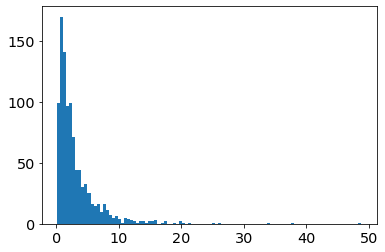

In [80]:
plt.hist(b, bins=100);

In [93]:
def simulate_data(N, n_genes=1000):
    
    # NB parameters
    nb_mean = stats.lognorm.rvs(s=1, scale=2)
    nb_theta = 2
    
    qs = stats.beta.rvs(alpha, beta, size=N)
    
    nb = stats.nbinom.rvs(*convert_params(nb_mean,nb_theta), size=(N, 1000))
    
    nb_obs = stats.binom.rvs(n=nb, p=np.vstack([qs for i in range(n_genes)]).T)
    
    # Create an ann data out of these
    obs_df = pd.DataFrame()
    obs_df['n_counts'] = [1e10 for i in range(N)]
    obs_df['cell_type'] = np.random.choice(['A', 'B'], size=N)
    values = sparse.csr_matrix(nb_obs)
    adata = sc.AnnData(
        values, 
        var=pd.DataFrame(index=['gene_' + str(i) for i in range(1, n_genes+1)]),
        obs=obs_df)
    
    return adata

In [136]:
def time_hypothesis_test(adata):
    
    
    
    imp.reload(scme)
    estimator = scme.SingleCellEstimator(
        adata=adata, 
        group_label='cell_type',
        n_umis_column='n_counts',
        num_permute=10000,
        beta=0.1)
    estimator.beta_sq = p_sq
    
    estimator.compute_observed_moments('A')
    estimator.compute_observed_moments('-A')
    estimator.compute_observed_moments('B')
    estimator.compute_observed_moments('-B')    
    estimator.estimate_parameters()
    
    start = time.time()
    estimator.compute_confidence_intervals_1d(
        groups=['A','B'],
        groups_to_compare=[('A', 'B')])
    
    return time.time() - start

In [137]:
a = simulate_data(1000)

Transforming to str index.


In [138]:
time_hypothesis_test(a)

Gamma RVs generated..


8.473587989807129

In [139]:
num_cells = np.logspace(2, 5, 10, endpoint=True)

In [140]:
num_cells

array([   100.        ,    215.443469  ,    464.15888336,   1000.        ,
         2154.43469003,   4641.58883361,  10000.        ,  21544.34690032,
        46415.88833613, 100000.        ])

In [149]:
a = simulate_data(200000)

KeyboardInterrupt: 

In [148]:
time_hypothesis_test(a)

KeyboardInterrupt: 

In [141]:
times = np.zeros(num_cells.shape[0])
for idx, N in enumerate(num_cells):
    print('On cell count', N, 'and idx', idx)
    data = simulate_data(int(N))
    times[idx] = time_hypothesis_test(data)

Transforming to str index.


On cell count 100.0 and idx 0
Gamma RVs generated..


Transforming to str index.


On cell count 215.44346900318845 and idx 1
Gamma RVs generated..


Transforming to str index.


On cell count 464.15888336127773 and idx 2
Gamma RVs generated..
On cell count 1000.0 and idx 3


Transforming to str index.


Gamma RVs generated..
On cell count 2154.4346900318824 and idx 4


Transforming to str index.


Gamma RVs generated..
On cell count 4641.588833612777 and idx 5


Transforming to str index.


Gamma RVs generated..
On cell count 10000.0 and idx 6


Transforming to str index.


Gamma RVs generated..
On cell count 21544.346900318822 and idx 7


Transforming to str index.


Gamma RVs generated..
On cell count 46415.888336127726 and idx 8


Transforming to str index.


Gamma RVs generated..
On cell count 100000.0 and idx 9


Transforming to str index.


Gamma RVs generated..


In [158]:
ifn_num_cells = np.array([100, 500, 1000, 2000, 3000, 5000, 10000, 20000])
ifn_times = np.array([
 20.869556665420532,
 35.29805541038513,
 38.040297746658325,
 46.348387002944946,
 58.43357753753662,
 87.58861637115479,
 142.3105809688568,
 222.7312273979187])

In [182]:
print(list(zip(num_cells, times)))

[(100.0, 6.929297208786011), (215.44346900318845, 12.625685453414917), (464.15888336127773, 6.224719762802124), (1000.0, 10.965573787689209), (2154.4346900318824, 9.975577116012573), (4641.588833612777, 14.064831018447876), (10000.0, 31.910074710845947), (21544.346900318822, 88.86108231544495), (46415.888336127726, 234.89731240272522), (100000.0, 339.7262473106384)]


In [184]:
sim_num_cells = np.array([   100.        ,    215.443469,  21544.34690032,
        46415.88833613, 100000.        ])
sim_times = np.array([
    6.92929721,  12.62568545,  88.86108232,
       234.8973124 , 339.72624731
])
sim_times = sim_times*(20.869556665420532/6.92929721)

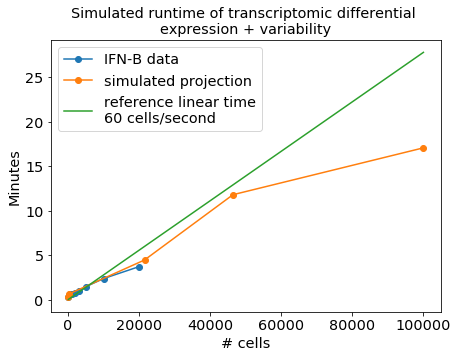

In [195]:
plt.figure(figsize=(7, 5))
plt.plot(ifn_num_cells, ifn_times/60, '-o', label='IFN-B data')
plt.plot(sim_num_cells, sim_times/60, '-o', label='simulated projection')
plt.plot(sim_num_cells, sim_num_cells/60/60, label='reference linear time\n60 cells/second')
plt.legend()
plt.title('Simulated runtime of transcriptomic differential \nexpression + variability')
plt.ylabel('Minutes');
plt.xlabel('# cells')
plt.savefig(data_path + 'figures/simulated_sublinear_runtime_combined.pdf', bbox_inches='tight')

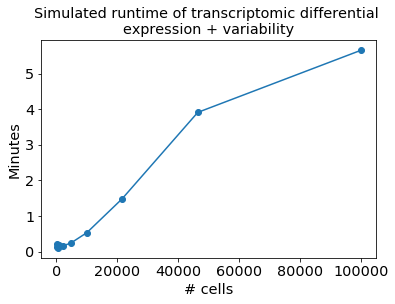

In [194]:
plt.plot(num_cells, times/60, '-o', label='runtime')
plt.title('Simulated runtime of transcriptomic differential \nexpression + variability')
plt.ylabel('Minutes');
plt.xlabel('# cells')
plt.savefig(data_path + 'figures/simulated_sublinear_runtime.pdf', bbox_inches='tight')

In [ ]:
plt.plot(times, np.array(perm_times)/60, '-o', label='runtime')
plt.plot(Ns, np.array(Ns)/60/60, label='ref. linear time\n60 cells/second')
plt.legend()
plt.title('Runtime of simulated transcriptomic differential \nexpression + variability')
plt.ylabel('Minutes');
plt.xlabel('# cells')
plt.savefig(data_path + 'figures/sublinear_runtime.pdf', bbox_inches='tight')

### Create an estimator and fit the simulated data

In [1140]:
imp.reload(scme)
estimator = scme.SingleCellEstimator(
    adata=adata, 
    group_label='cell_type',
    n_umis_column='n_counts',
    num_permute=10000,
    beta=0.1)
estimator.beta_sq = p_sq

In [1141]:
estimator.compute_observed_moments('A')
estimator.compute_observed_moments('-A')

In [1142]:
estimator.estimate_parameters()

In [1143]:
estimator.estimated_central_moments['A']['second'][1]

3.349983718142866

In [1144]:
norm_var

3

### Get the parameters to reconstruct the distributions

In [1145]:
est_poi_lambda = estimator.estimated_central_moments['A']['first'][0]# + estimator.estimated_central_moments['A']['second'][0])/2
est_norm_mean = estimator.estimated_central_moments['A']['first'][1]
est_norm_var = estimator.estimated_central_moments['A']['second'][1]
temp = 1 + estimator.estimated_central_moments['A']['second'][2]/estimator.estimated_central_moments['A']['first'][2]**2
est_lognorm_var = np.log(temp)
est_lognorm_mean = np.log(
    estimator.estimated_central_moments['A']['first'][2]) - np.log(np.sqrt(temp))
est_nb_mean = estimator.estimated_central_moments['A']['first'][3]
est_nb_theta = \
    1/((estimator.estimated_central_moments['A']['second'][3] - \
    estimator.estimated_central_moments['A']['first'][3])/ \
    estimator.estimated_central_moments['A']['first'][3]**2)

### Plot the simulation results

In [1169]:
def plot_distributions(x, true_pmf, est_poi_pmf, obs, title):
    
    fig, ax1 = plt.subplots()

    color = 'tab:brown'
    ax1.set_xlabel('mRNA content')
    ax1.set_ylabel('Observed probability', color=color)
    ax1.hist(obs, color=color, bins=np.bincount(obs).shape[0], density=True)
    ax1.set_title(title)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    ax2.set_ylabel('Latent probability')
    ax2.plot(x, est_poi_pmf, 
             marker='o' if title == 'Negative Binomial' or title == 'Poisson' else None,
             mfc='none', 
             ms=20, 
             linestyle='--', 
             mew=4, 
             linewidth=0 if title == 'Poisson' or title == 'Negative Binomial' else 7, 
             label='Estimated')
    ax2.plot(x, true_pmf, 
             marker='x' if title == 'Negative Binomial' or title == 'Poisson' else None, 
             mfc='none',
             ms=7, 
             linestyle='--', 
             mew=4, 
             linewidth=0 if title == 'Poisson' or title == 'Negative Binomial' else 7, 
             label='Ground truth')
    ax2.legend(labelspacing=1.3, borderpad=0.9)
    
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

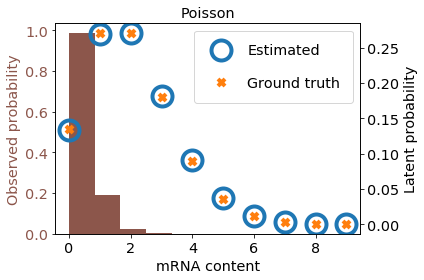

In [1170]:
x = np.arange(0, 10, 1)

plot_distributions(
    x, 
    stats.poisson.pmf(x, poi_lambda), 
    stats.poisson.pmf(x, est_poi_lambda), 
    poi_obs, 'Poisson')
plt.savefig(data_path + '../figures/simulation/poisson.pdf')
plt.savefig(data_path + '../figures/simulation/poisson.png')

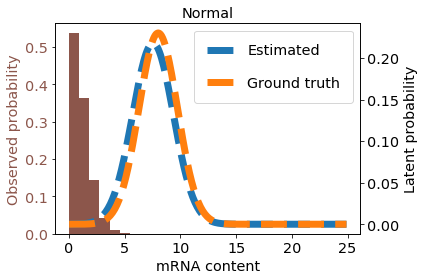

In [1171]:
x = np.arange(0, 25, 0.1)

plot_distributions(
    x, 
    stats.norm.pdf(x, norm_mean, np.sqrt(norm_var)), 
    stats.norm.pdf(x, est_norm_mean, np.sqrt(est_norm_var)), 
    norm_obs, 'Normal')
plt.savefig(data_path + '../figures/simulation/norm.pdf')
plt.savefig(data_path + '../figures/simulation/norm.png')

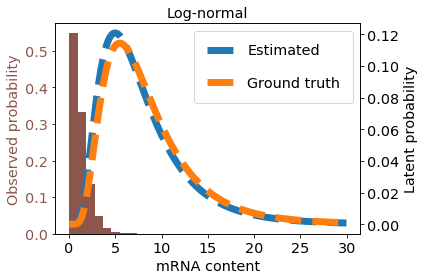

In [1172]:
x = np.arange(0, 30, 0.01)

plot_distributions(
    x, 
    stats.lognorm.pdf(x, scale=np.exp(lognorm_mean), s=np.sqrt(lognorm_var)), 
    stats.lognorm.pdf(x, scale=np.exp(est_lognorm_mean), s=np.sqrt(est_lognorm_var)), 
    lognorm_obs, 'Log-normal')
plt.savefig(data_path + '../figures/simulation/lognorm.pdf')
plt.savefig(data_path + '../figures/simulation/lognorm.png')

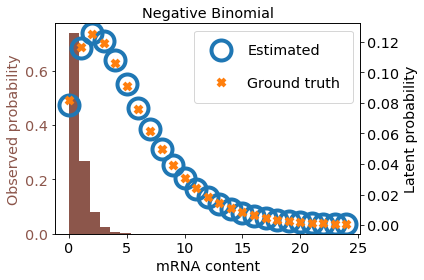

In [1173]:
x = np.arange(0, 25, 1)

plot_distributions(
    x, 
    stats.nbinom.pmf(x, *convert_params(nb_mean,nb_theta)), 
    stats.nbinom.pmf(x, *convert_params(est_nb_mean,est_nb_theta)), 
    nb_obs, 'Negative Binomial')
plt.savefig(data_path + '../figures/simulation/negbin.pdf')
plt.savefig(data_path + '../figures/simulation/negbin.png')